### This is a notebook highlighting some of the problems with using SVD before a linear model

In [1]:
import os
import math
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from images2gif import writeGif
import matplotlib.pyplot as plt
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [2]:
def svdout(xin, r):
    if r > xin.shape[1]:
        return 'r > k; r needs to be < k'
    
    U, s, V = np.linalg.svd(xin, full_matrices=False)
    D = np.diag(s)
    xpred = np.dot(U[:, 0:r], np.dot(D[0:r, 0:r], V[0:r,:]))
    return xpred

def predlm(xin, ys):
    mod = linear_model.LinearRegression().fit(xin, ys)
    pred = mod.predict(xin)
    rmse = np.sqrt( np.mean( (ys - pred)**2 )) 
    return rmse

def simSVD(n=1e4, k=50, eVar=1, l=10, seedval=0, corrMatrix=False):
    # next step add non-diagonal covariance
    np.random.seed(seedval)
    covmat = np.diag([eVar]*k)

    if corrMatrix==True:
        tmpcov = np.ones((k,k))
        for i in range(k):
            for j in range(k):
                tmpcov[i,j] = np.random.uniform(low=-0.8,high=0.8, size=1)
                #tmpcov[i,j] = np.random.standard_normal(size=1)
                tmpcov[j,i] = tmpcov[i,j]
        covmat=tmpcov

    xs = np.random.multivariate_normal(mean=np.zeros(k), cov=covmat, size=[int(n)])
    xs = (xs - np.mean(xs,axis=0)) / np.std(xs,axis=0)
    plt.imshow(np.cov(xs, rowvar=False))
    noise = np.random.normal(size=int(n), loc=0, scale=eVar)
    
    xsprd = svdout(xs, r=l)
    eps = xs - xsprd
    bs = np.ones(k)
    y = eps.dot(bs) + noise
    
    orig_perf = predlm(xs, y)
    svd_perf = predlm(xsprd, y)
    
    return pd.DataFrame([l, orig_perf, svd_perf, svd_perf/orig_perf], index=['RankApprox','Orig','SVD', 'Ratio']).T

,RankApprox,Orig,SVD,Ratio
0,10,0.990741,6.616464,6.678298


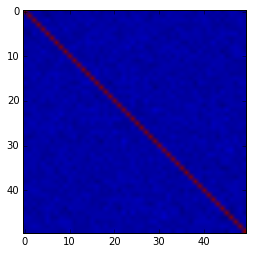

In [4]:
simSVD()

/Users/franciscojavierarceo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: covariance is not positive-semidefinite.


,RankApprox,Orig,SVD,Ratio
0,10,1.001723,4.622032,4.61408


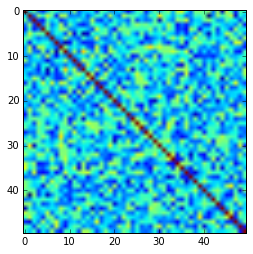

In [5]:
simSVD(corrMatrix=True)

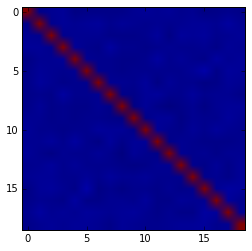

In [6]:
# With a varying error term
ncols, rankr, orig, svds, rati, error = [], [], [], [], [], []
for e in tqdm(range(10,31)):
    for j in range(10, 20):
        for i in range(j):
            tmp = simSVD(n=3e4, k = j, eVar=(e/10.0), l=i, seedval=1).values.tolist()[0]
            ncols.append(j)
            rankr.append(i)
            error.append(e/10.0)
            orig.append(tmp[1])
            svds.append(tmp[2])
            rati.append(tmp[3])

In [8]:
out = pd.DataFrame([ncols,rankr,orig,svds,rati,error], index=['NCols','RankApprox','Orig','SVD','Ratio', "Error"]).T
bnds = [int(np.min(out['Ratio'])), int(math.ceil(np.max(out['Ratio'])))]

In [11]:
out.head()

,NCols,RankApprox,Orig,SVD,Ratio,Error
0,10,0,0.99671,3.327917,3.338901,1
1,10,1,0.99671,3.319333,3.330289,1
2,10,2,0.99671,3.098051,3.108276,1
3,10,3,0.99671,2.809459,2.818731,1
4,10,4,0.99671,2.402991,2.410923,1


This is a bit of a ghetto work around the animation.  I'm exporting everything into a bunch of pngs and then converting it to a gif. I'll clean this up to  only export it as a gif soon...

In [19]:
es = list(set(out.Error))
es.sort(reverse=True)
for idx, i in enumerate(es):
    X, Y, Z = out.ix[out['Error']==i,'RankApprox'], out.ix[out['Error']==i,'NCols'], out.ix[out['Error']==i,'Ratio']
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(X, Y, Z, cmap=cm.bwr, norm=plt.Normalize(vmin=1, vmax=3.5))
    ax.set_zlim(bnds[0], bnds[1])
    ax.set_title('3d Plot of SVD with Model Error ='+str(i)+'\n' +'Iteration '+str(idx) +'\n \n')
    ax.set_ylabel('Low Rank Approximation Size')
    ax.set_xlabel('True Rank')
    ax.set_zlabel('Ratio of True Rank Model and Low Rank Error')
    plt.close()
    fig.savefig('3dplot'+str(idx).zfill(2)+'.png')
    
# This will export a gif of all of the images
file_names = [f for f in os.listdir('./') if f.startswith('3dplot')]
file_names.sort()
images = [Image.open(fn) for fn in file_names]
writeGif("3dplot_gif.GIF", images, duration=0.5)

## Need to fix the corrMatrix function for inversion issues
### Now using a varying error term and correlated design matrix

In [ ]:
ncols, rankr, orig, svds, rati, error = [], [], [], [], [], []
for e in tqdm(range(10,31)):
    for j in range(10, 20):
        for i in range(j):
            tmp = simSVD(n=1e5, k = j, eVar=(e/10.0), l=i, seedval=1, corrMatrix=True).values.tolist()[0]
            ncols.append(j)
            rankr.append(i)
            error.append(e/10.0)
            orig.append(tmp[1])
            svds.append(tmp[2])
            rati.append(tmp[3])

In [ ]:
out = pd.DataFrame([ncols,rankr,orig,svds,rati,error], index=['NCols','R','Orig','SVD','Ratio', "Error"]).T
bnds = [int(np.min(out['Ratio'])), int(math.ceil(np.max(out['Ratio'])))]
for i in range(1,10):
    X, Y, Z = out.ix[out['Error']==i,'R'], out.ix[out['Error']==i,'NCols'], out.ix[out['Error']==i,'Ratio']
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(X, Y, Z, cmap=cm.jet)
    #ax.set_zlim(bnds[0],bnds[1])
    ax.set_title('3d Plot of SVD and Model Error \n \n')
    ax.set_ylabel('Low Rank Approximation Size')
    ax.set_xlabel('True Rank')
    ax.set_zlabel('Ratio of True Rank Model and Low Rank Error')
    plt.close()
    fig.savefig('3dplotcorr'+str(i)+'.png')

## TO DO: Make the animation below work

In [ ]:
# Need to get this to work for 3d plot
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=25, interval=20, blit=True)

# call our new function to display the animation
display_animation(anim)

In [ ]:
from matplotlib import animation
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax = fig.gca(projection='3d')
# ax.plot_trisurf(X, Y, Z, cmap=cm.jet)
# ax.set_title('3d Plot of SVD and Model Error \n \n')
# ax.set_ylabel('Low Rank Approximation Size')
# ax.set_xlabel('True Rank')
# ax.set_zlabel('Ratio of True Rank Model and Low Rank Error')
grph, = ax.plot_trisurf([], [], [])

def init():
    grph.set_data(X, Y, Z)
    return grph,

def animate(out, i):
    X, Y, Z = out.ix[out['Error']==i,'R'], out.ix[out['Error']==i,'NCols'], out.ix[out['Error']==i,'Ratio']
    grph.set_data(X, Y, Z)
    return grph,

#anim = animation.FuncAnimation(fig, animate, init_func=init,
#                               frames=5, interval=20, blit=True)

#display_animation(anim)

## TO DO: Make the plot_surface function work

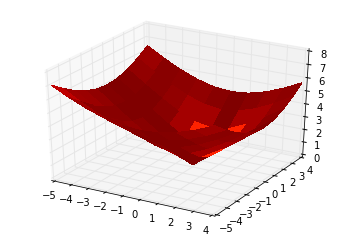

In [27]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(-5, 5, 1)
Y = np.arange(-5, 5, 1)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = R #np.sin(R)
Gx, Gy = np.gradient(Z) # gradients with respect to x and y
G = (Gx**2+Gy**2)**.5  # gradient magnitude
N = G/G.max()  # normalize 0..1
surf = ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1,
    facecolors=cm.jet(N),
    linewidth=0, antialiased=False, shade=False)
plt.show()